In [ ]:
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Colab Notebooks/Capstone/clustering/gnews2.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
df = pd.read_csv(file_path)

In [8]:
df.columns

Index(['id', 'title', 'link', 'published', 'source', 'summary', 'query',
       'fetched_at'],
      dtype='object')

### **Get rid of the missing value and null value.**

In [11]:
df_cleaned = df.dropna(subset=['summary'])
df_cleaned = df_cleaned[~df_cleaned['summary'].str.startswith('I am unable')]
df_cleaned = df_cleaned[~df_cleaned['summary'].str.startswith('The article at')]

df_cleaned = df_cleaned.reset_index(drop=True)

print(f"Original shape: {df.shape}")
print(f"Cleaned shape: {df_cleaned.shape}")

Original shape: (665, 8)
Cleaned shape: (320, 8)


## Vectorize

Convert the 'summary' text in `df_cleaned` into numerical vectors using `TfidfVectorizer`.


Import TfidfVectorizer, instantiate it with English stop words, transform the 'summary' column, and print the resulting matrix shape as per instructions.



In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate the vectorizer with English stop words
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the 'summary' column
tfidf_matrix = vectorizer.fit_transform(df_cleaned['summary'])

# Print the shape of the resulting TF-IDF matrix
print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")

TF-IDF Matrix Shape: (320, 2629)


In [17]:
# Get the feature names from the TF-IDF vectorizer
feature_names = vectorizer.get_feature_names_out()

for i in range(5):
    # Find the indices of the top 10 features (words) with the highest weights in the centroid
    top_indices = kmeans_optimal.cluster_centers_[i].argsort()[-10:][::-1]
    top_words = [feature_names[ind] for ind in top_indices]

    print(f"Cluster {i} Top Words: {', '.join(top_words)}")

    # Display the titles of the first 3 articles in this cluster for context
    print("Example Titles:")
    print(df_cleaned[df_cleaned['cluster'] == i]['title'].head(3).to_string(index=False))
    print("\n" + "="*50 + "\n")

Cluster 0 Top Words: health, new, digital, public, abortion, data, state, access, potential, legal
Example Titles:
BNY Mellon High Yield Strategies Fund Declares ...
Florida State brings defensive 'urgency' into G...
Virginia expecting test from Northwestern in We...


Cluster 1 Top Words: ipad, chip, inch, pro, air, apple, models, event, display, loose
Example Titles:
2026–27 Institute on AI, Pedagogy, and the Curr...
Should Your AC Be Set to “Auto” or “On”? HVAC E...
With SB 53, California puts AI disclosure requi...


Cluster 2 Top Words: report, new, discusses, details, local, piece, article, challenges, efforts, international
Example Titles:
Theoretical Chemist Lauded With 2025 Henry Drey...
A Look at Bank of New York Mellon’s (BK) Valuat...
Ice rink returns to Pershing Square in Downtown...


Cluster 3 Top Words: energy, supply, global, economic, particularly, costs, housing, market, impact, new
Example Titles:
Ohio State rides clutch performance into clash ...
Bank of New York M

## Determine Optimal Clusters

Calculate WCSS for a range of cluster counts and plot the Elbow curve to identify the optimal number of clusters.


Import KMeans and matplotlib, calculate WCSS for cluster counts from 1 to 15 using the TF-IDF matrix, and generate an Elbow plot to visualize the optimal number of clusters.



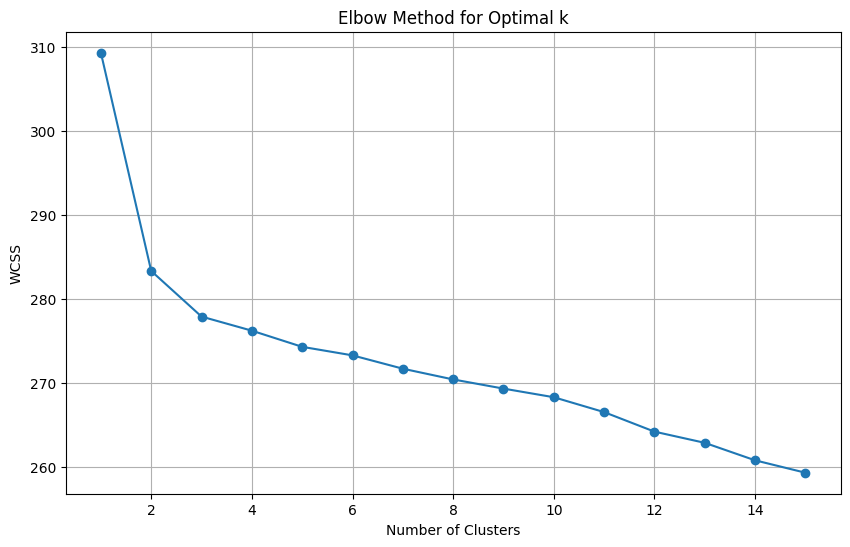

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Initialize list to store WCSS
wcss = []

# Iterate through a range of cluster numbers from 1 to 15
for i in range(1, 16):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 16), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

## Perform K-Means Clustering

Apply the K-Means clustering algorithm using the optimal number of clusters (k=5) and assign labels.


Initialize KMeans with 5 clusters, fit it to the TF-IDF matrix, assign the cluster labels to the dataframe, and display the cluster distribution.



In [14]:
kmeans_optimal = KMeans(n_clusters=5, random_state=42, n_init='auto')

kmeans_optimal.fit(tfidf_matrix)

df_cleaned['cluster'] = kmeans_optimal.labels_

print(df_cleaned['cluster'].value_counts())

cluster
2    114
0     72
4     48
3     46
1     40
Name: count, dtype: int64


## Visualize Clusters

Reduce the dimensionality of the vectorized data to 2 dimensions using PCA and generate a scatter plot to visualize the clusters.


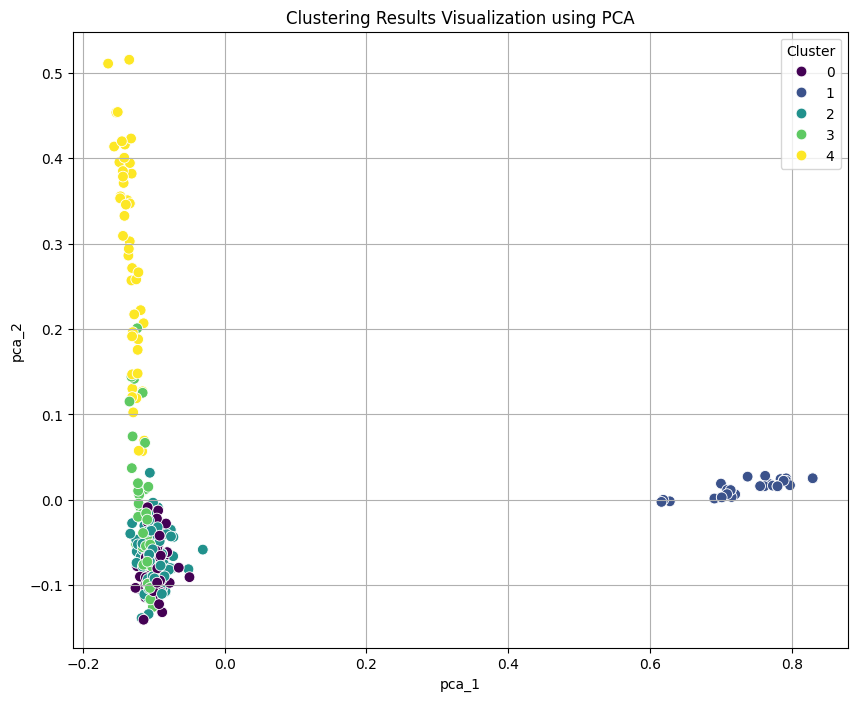

In [15]:
from sklearn.decomposition import PCA
import seaborn as sns

# Instantiate PCA with 2 components
pca = PCA(n_components=2, random_state=42)

# Fit and transform the dense TF-IDF matrix
pca_result = pca.fit_transform(tfidf_matrix.toarray())

# Store PCA components in the DataFrame
df_cleaned['pca_1'] = pca_result[:, 0]
df_cleaned['pca_2'] = pca_result[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='pca_1', y='pca_2', hue='cluster', data=df_cleaned, palette='viridis', s=60)
plt.title('Clustering Results Visualization using PCA')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

Display example articles from each cluster to interpret the topics.


Cluster 0: Public Health & Policy

Keywords: health, public, abortion, data, state, access, legal.  
Focus: This cluster appears to cover social and political issues, specifically focusing on public health, legal rights, and state-level regulations.


Cluster 1: Technology (Consumer Electronics)

Keywords: ipad, chip, inch, pro, air, apple, models, display.  
Focus: This is a very distinct cluster focused on technology hardware, specifically Apple products and new gadget releases.


Cluster 2: General News & Reporting

Keywords: report, new, discusses, details, local, international.  
Focus: This is the largest cluster and seems to be a "catch-all" for general reporting that doesn't fit strictly into the other specific categories, covering a mix of local and international stories.


Cluster 3: Energy, Housing & Supply Chain

Keywords: energy, supply, global, costs, housing, market.  
Focus: This cluster deals with specific market sectors, particularly energy supplies, housing costs, and global economic factors affecting these industries.


Cluster 4: Macroeconomics & Monetary Policy

Keywords: inflation, economic, economy, reserve, federal, rate, recession.  
Focus: Distinct from Cluster 3, this cluster focuses on high-level economic indicators, such as Federal Reserve policies, inflation rates, and recession fears.
